In [1]:
from tqdm.notebook import tqdm # this module is useful to plot progress bars
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from DataReader import DataReader

from particlenet import ParticleNet
from particlenet_decoder import ParticleNetDecoder, ParticleNetDecoder_1feat

## Data Loading

In [2]:
class ParticleDataset(Dataset):

    def __init__(self, data_reader, n_files=None, transform=None):

        data_reader.read_files(n_files=n_files)

        self.x = data_reader.get_features()
        self.y = data_reader.get_labels()

        self.transform = transform
        

    def __len__(self):

        return self.x.shape[0]
    

    def __getitem__(self, idx):

        x = self.x[idx]
        y = self.y[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y

In [28]:
train_transform = None #transforms.Compose([transforms.ToTensor()])

data_reader = DataReader("../data/train/")

train_data = ParticleDataset(data_reader=data_reader, n_files=10, transform=train_transform)

Reading file jetImage_5_100p_20000_30000.h5
Reading file jetImage_2_100p_60000_70000.h5
Reading file jetImage_3_100p_20000_30000.h5
Reading file jetImage_6_100p_50000_60000.h5
Reading file jetImage_4_100p_20000_30000.h5
Reading file jetImage_0_100p_80000_90000.h5
Reading file jetImage_5_100p_10000_20000.h5
Reading file jetImage_3_100p_40000_50000.h5
Reading file jetImage_2_100p_50000_60000.h5
Reading file jetImage_2_100p_10000_20000.h5


In [29]:
batch_size       = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)

next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[0].dtype

(torch.Size([64, 100, 7]), torch.float32)

## Models

In [5]:
latent_space_dim = 4
n_features = 7
n_partjet = 100

encoder = ParticleNet(n_features, latent_space_dim)
decoder = ParticleNetDecoder_1feat(latent_space_dim, n_partjet, n_features)

## Training function

In [6]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder = encoder.to(device)
decoder = decoder.to(device)

Selected device: cuda


### LR Scheduler

In [24]:
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR, ExponentialLR

### Define an optimizer (both for the encoder and the decoder!)
lr = 3e-4 # Learning rate

#function for the custom learning rate:
def custom_lr(epoch, lr = 3e-4):

    if epoch < 8: # linear increase
        return lr + 1.125e-4 * epoch
    if (epoch >= 8 and epoch < 16): # linear decrease
        return lr*10 - 1.125e-4 * (epoch - 8 )
    if epoch >= 16: # linear decrease
        return lr - 7.4825e-5 * (epoch - 16)

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=custom_lr)


In [26]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()

    # abbiamo già definito l'optimizer nella cella precedente
    
    losses = []
    pbar = tqdm(dataloader, 'Steps')
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for batch, _ in pbar: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        
        batch = batch.to(device)
        #encode
        y_encoder_pred = encoder(batch)
        #decode
        y_decoder_pred = decoder(y_encoder_pred)

        loss = loss_fn(y_decoder_pred, batch) # funziona anche per le matrici in teoria

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss.detach().cpu().numpy())
        pbar.set_postfix_str(f'loss: {losses[-1]:.2f}')
    
    losses = np.mean(losses)
    return losses

## Testing function

In [17]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()

    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in tqdm(dataloader, 'Steps'):
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training

In [30]:
### Training cycle
num_epochs = 20
pbar = tqdm(range(num_epochs), 'Epoch')
for epoch in pbar:

    ### Training (use the training function)
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    pbar.set_postfix_str(f'loss: {train_loss}')
    '''
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print(f'VALIDATION - EPOCH {epoch+1}/{num_epochs} - loss: {val_loss}\n')
    '''
    ### step of the lr scheduler
    scheduler.step() # alla fine di ogni epoca

    ### Plot progress

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

Steps:   0%|          | 0/1563 [00:00<?, ?it/s]

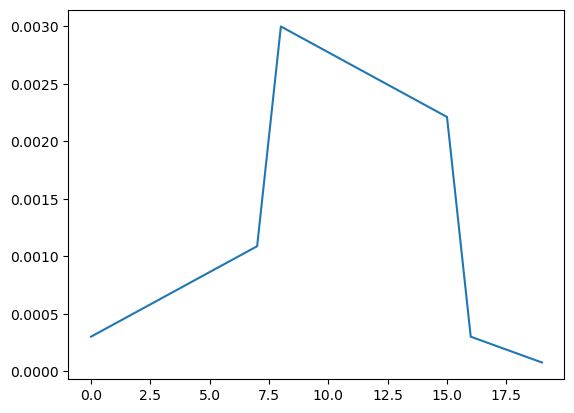

In [11]:
x = np.arange(20)

plt.plot(x, [custom_lr(e) for e in x])